In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import ellc

In [ ]:
lit_period = 51.4213
lit_t0 = 2458901.6949978997

In [ ]:
ref_rv = 2400000

x_rv_primary, y_rv_primary = np.loadtxt('data/RV/SONG.txt', usecols=(0,1)).T
x_rv_secondary, y_rv_secondary = np.loadtxt('data/RV/SONG_secondary.txt', usecols=(0,1)).T

plt.plot(x_rv_primary, y_rv_primary, '.k')
plt.plot(x_rv_secondary, y_rv_secondary, '.k')

In [ ]:
x_rv = np.ascontiguousarray(x_rv_primary + ref_rv, dtype=np.float64)
y1_rv = np.ascontiguousarray(y_rv_primary, dtype=np.float64)
# y1_rv -= np.median(y1_rv)
y2_rv = np.ascontiguousarray(y_rv_secondary, dtype=np.float64)
# y2_rv -= np.median(y2_rv)


fold = (x_rv - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period

m = (fold < 1) & (fold > -1)
x_rv = x_rv[~m]
y1_rv = y1_rv[~m]
y2_rv = y2_rv[~m]

fold = (x_rv - lit_t0 + 0.5 * lit_period) % lit_period - 0.5 * lit_period


plt.plot(fold, y1_rv, ".", label="primary")
plt.plot(fold, y2_rv, ".", label="secondary")
plt.legend(fontsize=10)
plt.xlim(-0.5 * lit_period, 0.5 * lit_period)
plt.ylabel("radial velocity [km / s]")
_ = plt.xlabel("time since primary eclipse [days]")

In [9]:
def rv_model(params, x):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv, q = params
    r1, r2 = rsum/(1.+rratio), rsum*rratio/(1.+rratio)
    rv = ellc.rv(x,t_zero=t0,
                radius_1=r1, radius_2=r2,
                incl=incl,
                sbratio=sbratio,# shape_1='sphere', shape_2='sphere',
                period=period, f_c=f_c, f_s=f_s, q=q,
                a=sma,)
    return rv[0], rv[1]

def lnlike(params, x, y, yerr, x_rv, y_rv, yerr_rv):
    period, rsum, rratio, incl, sbratio, t0, f_c, f_s, sma, gammav, q11, q12, q21, q22, domdt, loglc, logrv = params
    lp = lnprior(params)
    if not np.isfinite(lp):
        return -np.inf
    # LC
    model_flux = lc_model(params, x)
    sigma2 = yerr ** 2+ model_flux ** 2 * np.exp(2 * loglc)
    ln_lc = -0.5*np.sum((y-model_flux)**2/sigma2 + np.log(sigma2))

    # RV
    model_rv = rv_model(params, x_rv)
    sigma2 = yerr_rv ** 2 + model_rv ** 2 * np.exp(2 * logrv)
    ln_rv = -0.5*np.sum((y_rv-model_rv)**2/sigma2 + np.log(sigma2))

    return ln_lc + ln_rv
    
from scipy.optimize import minimize
nll = lambda *args: -lnlike(*args)

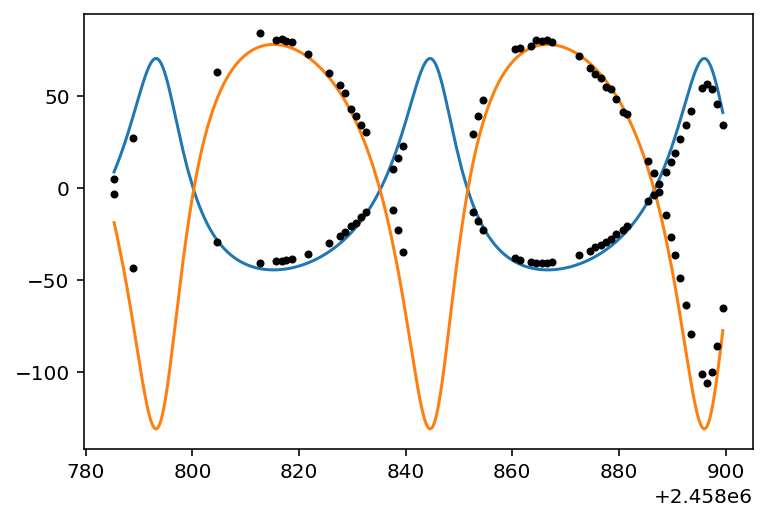

In [24]:
params = np.array([
    5.14192040e+01, # Period
    0.0703, # Rsum
    0.4489, # Rratio
    8.62150418e+01, # Incl
    0.1, # Sbratio
    lit_t0, # t0
    6.20730605e-01, # fc
    1.60481296e-01, # fs
#     0., #logf
#     0., #mean
    150, #sma
    0, #gammav
    2.68060970e-01, # q11
    4.55712020e-01, # q12
    8.30538026e-01, # q21
    5.82431661e-02, # q22
    0., #domdt
    0., #loglc
    0., #logrv
    0.55, #q
])

test_time = np.linspace(x_rv[0], x_rv[-1], 10000)
a, b = rv_model(params, test_time)
cc = -10
plt.plot(test_time, a-10)
plt.plot(test_time, b+15)
plt.plot(x_rv, y1_rv, '.k')
plt.plot(x_rv, y2_rv, '.k')
plt.show()

# b = lc_model(params, full_transit_time)
# plt.plot(full_transit_time, b)
# plt.plot(full_transit_time, full_transit_flux, '.k')
plt.show()